<a href="https://colab.research.google.com/github/VictorIM1/Invatare-Supervizata/blob/main/(Lab%208)%20colorectal_polyp_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laborator 8 - Aplicații pentru cancerul colorectal

Aplicațiile de inteligență artificială (AI) în detectarea cancerului colorectal din colonoscopii au un impact
semnificativ asupra prevenției și tratamentului acestuia, fiind una dintre principalele cauze de mortalitate la nivel
 global. Inteligentța Artificială poate ajuta medicii să identifice polipii colorectal, uneori greu de observat, în
 timp real,
 crescând astfel rata de detecție și reducând riscul ca leziuni precanceroase să fie trecute cu vederea. Algoritmii
 avansați de procesare a imaginilor pot clasifica leziunile în funcție de risc și pot oferi alerte pentru imagini
 neclare, îmbunătățind atât calitatea procedurii, cât și siguranța pacientului. Prin automatizarea unor procese
 complexe, inteligența artificială reduce variabilitatea deciziilor clinice și sprijină personalul medical în luarea
 unor
 decizii rapide și precise, contribuind astfel la salvarea de vieți și optimizarea resurselor medicale.



## Importări

In [ ]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")  # remove some scikit-image warnings

from monai.data import DataLoader, CacheDataset, Dataset
from monai.networks.nets import Unet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import (
    Compose,
    AsDiscreteD,
    EnsureTyped,
    LoadImageD,
    EnsureChannelFirstD,
    ScaleIntensityD,
    ResizeD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ToTensorD, LambdaD,
)

from tqdm import tqdm
from zipfile import ZipFile

import requests
import torch
import numpy as np
import matplotlib.pyplot as plt

## Setul de date

În cadrul acestui laborator, vom utiliza KvasirSeg, un set de date de testare care conține 1000 de imagini din
colonoscopii. Scopul acestui set de date este de a indentifica polipii colorectali și de a-i evidenția folosind
tehnica de segmentare semantică. Imaginile sunt împărțite în 2 directoare:
  - `images` &rarr; imaginile din setul de date în format `.jpg`
  - `masks` &rarr; măștile corespunzătoare imaginilor în format `.jpg`

Setul de date este disponibil la adresa: https://datasets.simula.no/downloads/kvasir-seg.zip


### Constante

In [ ]:
# Data download and manipulation
ROOT_DIR = "./dataset/Kvasir-SEG"  # the root directory containing the images and masks
DATASET_URL = "https://datasets.simula.no/downloads/kvasir-seg.zip"  # the URL of the dataset
TRAIN_RATIO = 0.8  # the ratio of training data to the total data
VAL_RATIO = 0.1  # the ratio of validation data to the total data

# Do not update the following constants
LOADER_KEYS = ['image', 'mask']  # Keys used by data loader. DO NOT CHANGE

### Încărcarea datelor

Datele se vor descărca în mod automat de la adresa setată în constanta `DATASET_URL`, după care va fi încărcat de la
locația din `ROOT_DIR`.

In [ ]:
def download_dataset(dataset_url: str,
                     zip_file_name: str,
                     root_dir: str) -> None:
    """
    Download a dataset from a given URL and extract it to a specified directory.
    :param dataset_url: The URL of the dataset to download.
    :param zip_file_name: The name of the zip file to download.
    :param root_dir: The root directory where the dataset will be downloaded and extracted.
    """
    # Ensure the target directory exists
    os.makedirs(root_dir, exist_ok=True)

    # Path to the local zip file
    zip_file_path = os.path.join(root_dir, zip_file_name)

    # Check if the zip file already exists
    if not os.path.exists(zip_file_path):
        print(f"Downloading dataset from {dataset_url}...")
        # Download the zip file
        response = requests.get(dataset_url, stream=True)
        if response.status_code == 200:
            with open(zip_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            print(f"Downloaded dataset to {zip_file_path}.")
        else:
            raise RuntimeError(f"Failed to download the dataset. Status code: {response.status_code}")
    else:
        print(f"Dataset zip file already exists at {zip_file_path}.")

    # Extract the zip file
    extracted_dir = os.path.join(root_dir, "dataset")
    if not os.path.exists(extracted_dir):
        print(f"Extracting dataset to {extracted_dir}...")
        with ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(extracted_dir)
        print(f"Extracted dataset to {extracted_dir}.")
    else:
        print(f"Dataset already extracted at {extracted_dir}.")

    return extracted_dir

In [ ]:
def get_data_dicts(root_dir: str) -> list[dict]:
    """
    Get a list of dictionaries containing paths to images and masks.
    :param root_dir: The root directory containing the images and masks.
    :return: A list of dictionaries, where each dictionary contains paths to an image and its corresponding mask.
    """
    # The root directory contains two subdirectories: images and masks
    images_dir = os.path.join(root_dir, "images")
    masks_dir = os.path.join(root_dir, "masks")

    # Get a list of image and mask file paths
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg'))])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg'))])
    return [{"image": img, "mask": msk} for img, msk in zip(image_files, mask_files)]


def split_data(data: list[dict],
               train_ratio: float = 0.8,
               val_ratio: float = 0.1,
               shuffle: bool = False,
               seed: int = 42):
    """
    Split the data into training, validation, and test sets.

    :param data: A list of dictionaries, where each dictionary contains paths to an image and its corresponding mask.
    :param train_ratio: The ratio of data to be used for training.
    :param val_ratio: The ratio of data to be used for validation.
    :param shuffle: Shuffle the dataset if set to `True`
    :param seed: The seed for the random number generator.
    :return: A tuple containing the training, validation, and test data dictionaries.
    """

    # Check if the total ratio is greater than 1
    if train_ratio + val_ratio > 1:
        raise ValueError("The total ratio should not be greater than 1")

    if shuffle:
        # Shuffle the data
        np.random.seed(seed)
        np.random.shuffle(data)

    # Calculate the number of samples for each set
    total_samples = len(data)
    train_samples = int(train_ratio * total_samples)
    val_samples = int(val_ratio * total_samples)

    # Split the data into training, validation, and test sets
    train_data = data[:train_samples]
    val_data = data[train_samples:train_samples + val_samples]
    test_data = data[train_samples + val_samples:]
    return train_data, val_data, test_data

In [ ]:
# Download the dataset
download_dataset(DATASET_URL, "dataset.zip", "./")

Dataset zip file already exists at ./dataset.zip.
Dataset already extracted at ./dataset.


'./dataset'

In [ ]:

# Get the file paths as a list of dictionaries
data_dicts = get_data_dicts(ROOT_DIR)

# Split the data into training, validation, and test sets
train_data_dict, val_data_dict, test_data_dict = split_data(data=data_dicts,
                                                            train_ratio=TRAIN_RATIO,
                                                            val_ratio=VAL_RATIO)

### Vizualizarea datelor

Vizualizarea datelor este importantă pentru a înțelege mai bine informațiile și pentru a descoperi tipare sau erori care nu sunt evidente în format brut. În special, atunci când lucrăm cu modele AI, este util să vizualizăm datele și după ce aplicăm augmentările, ca să ne asigurăm că transformările sunt corecte și că nu modifică semnificativ semnificația datelor. Acest pas ajută la crearea unui model mai robust și la evitarea problemelor neașteptate în timpul antrenării.

In [ ]:
def show_image_with_mask(image: np.ndarray,
                         mask: np.ndarray,
                         alpha=0.5,
                         figsize=(10, 5),
                         cmap="jet"):
    """
    Displays the original image and the image with an overlapped mask side by side.

    Args:
        image (numpy.ndarray or torch.Tensor): The original image. Shape: (H, W) or (C, H, W).
        mask (numpy.ndarray or torch.Tensor): The mask to overlay. Shape: (H, W).
        alpha (float): Transparency of the mask overlay. Default is 0.5.
        figsize (tuple): Size of the figure. Default is (10, 5).
        cmap (str): Colormap for the mask. Default is "jet".
    """
    # Ensure image and mask are numpy arrays
    if hasattr(image, "numpy"):
        image = image.numpy()
    if hasattr(mask, "numpy"):
        mask = mask.numpy()

    # Verify the image is in RGB format
    if image.ndim != 3:
        raise ValueError("Input image must be an RGB image with shape (H, W, 3).")

    # Image must be in (H, W, C) format
    if image.shape[2] != 3:
        image = np.transpose(image, (1, 2, 0))
        mask = np.transpose(mask, (1, 2, 0))

    # Normalize image to [0, 1] for visualization if needed
    if image.max() > 1.0:
        image = image / 255.0
        mask = mask / 255.0

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image)
    axes[1].imshow(mask, cmap=cmap, alpha=alpha)
    axes[1].set_title("Image with Mask Overlay")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Loader for the original image
loader = Compose([
    LoadImageD(keys=LOADER_KEYS),  # Load the image and mask
    EnsureTyped(keys=LOADER_KEYS, data_type="numpy"),  # Convert to numpy array
])

In [ ]:
MAX_EXAMPLES = 5  # Maximum number of examples to display

# Show N examples from the dataset
for idx in range(0, len(data_dicts)):
    if idx >= MAX_EXAMPLES:
        break
    image_data = loader(data_dicts[idx])
    show_image_with_mask(image_data['image'], image_data['mask'])

#### Exercițiul 1 - vizualizarea augmentărilor

Un pas important din procesul de antrenare al unui model de machine learning este preprocesarea datelor. Aceasta
implică transformarea datelor de intrare într-un format compatibil cu modelul de antrenare. În cazul nostru, folosim
`Compose` pentru a compune mai multe transformări pe datele de intrare. Înainte de a antrena modelul cu aceste transformări,
este important să înțelegem modul în care acestea afectează datele.

Aplicați următoarele transformări:
- Resize la dimensiune de (512, 512)
- Flip orizontal și vertical
- Rotire
- Zoom
- Crop

Asigurați-vă că augmentările nu afectează poziția măștilor relativ la zonele de interes din imagine.

**HINT**: utilizați o probabilitate de 1.0 pentru fiecare transformare pentru a fi mai ușor de vizualizat rezultatele.

Original image:
	image shape: (622, 529, 3) 
	mask shape: (622, 529, 3)
Transformed image:
	image shape: (3, 512, 512) 
	mask shape: (3, 512, 512)



Original image:


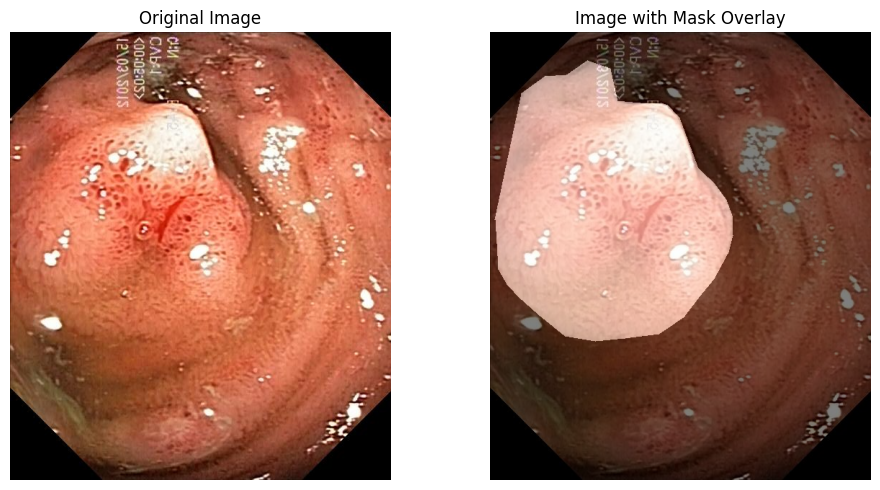


Transformed image:


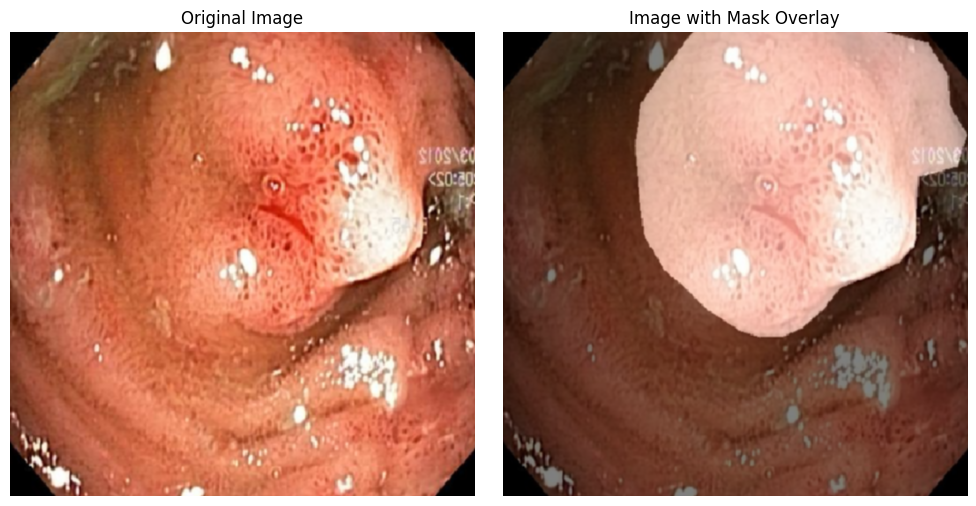

In [ ]:
IMAGE_IDX = 0
from monai.transforms import (
    ResizeD,
    RandFlipD,
    RandRotate90D,
    RandZoomD,
    RandSpatialCropD
)
# Loader for the transformed image
transform_loader = Compose([
    LoadImageD(keys=LOADER_KEYS),  # Load the image and mask
    EnsureChannelFirstD(keys=LOADER_KEYS),  # Ensure the channel dimension is first
    # TODO 1: Add augmentations here
    ResizeD(keys=LOADER_KEYS, spatial_size=(512, 512)),  # Resize la dimensiune fixa
    RandFlipD(keys=LOADER_KEYS, prob=1.0, spatial_axis=0),  # Flip orizontal
    RandFlipD(keys=LOADER_KEYS, prob=1.0, spatial_axis=1),  # Flip vertical
    RandRotate90D(keys=LOADER_KEYS, prob=1.0, max_k=1),  # Rotire la 90
    RandZoomD(keys=LOADER_KEYS, prob=1.0, min_zoom=1.0, max_zoom=1.2),  # Zoom
    RandSpatialCropD(keys=LOADER_KEYS, roi_size=(512, 512), random_center=True, random_size=False),
    EnsureTyped(keys=LOADER_KEYS, data_type="numpy"),  # Convert to numpy array
])


original_image_data = loader(data_dicts[IMAGE_IDX])
transformed_image_data = transform_loader(data_dicts[IMAGE_IDX])

# Show shape differences between original and transformed image
print(f"Original image:")
print(f"\timage shape: {original_image_data['image'].shape} \n\tmask shape: {original_image_data['mask'].shape}")

print(f"Transformed image:")
print(f"\timage shape: {transformed_image_data['image'].shape} \n\tmask shape: {transformed_image_data['mask'].shape}")

# Show differences between original and transformed image
print(f"\n\n\nOriginal image:")
show_image_with_mask(original_image_data['image'], original_image_data['mask'])
print(f"\nTransformed image:")
show_image_with_mask(transformed_image_data['image'], transformed_image_data['mask'])

### Definirea setului de date
Transformările pentru:
- **Setul de antrenare** &rarr; Augmentări multiple pentru a ajuta modelul să generalizeze și să devină mai robust.
- **Setul de testare** &rarr; Fără augmentări pentru a evalua performanța modelului pe date reale, neafectate.

In [ ]:
# Test transforms
test_transforms = Compose([
    LoadImageD(keys=LOADER_KEYS),
    EnsureChannelFirstD(keys=LOADER_KEYS),
    ResizeD(keys=LOADER_KEYS,
            spatial_size=(512, 512)),
    ScaleIntensityD(keys="image"),
    LambdaD(
        keys="mask",
        func=lambda x: x.mean(axis=0, keepdims=True) / 255.0
    ),
    AsDiscreteD(keys="mask", to_onehot=2),
    ToTensorD(keys=LOADER_KEYS)]
)

#### Exercițiul 2 - aplicarea augmentărilor

Plecând de la exemplul transformărilor aplicate pe setul de testare și pe baza experimentelor de la primul exercițiu,
 adăugați în lista de transformări diverse augmentări pentru a crește în mod dinamic variabilitatea setului de date
 de antrenare.

In [ ]:
# Train transforms
from monai.transforms import (
    ResizeD,
    ScaleIntensityD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    RandGaussianNoiseD,
    RandAdjustContrastD,
    RandAffineD,
    RandGridDistortionD,
    RandGaussianSmoothD,
    RandScaleIntensityD,
    AsDiscreteD,
    ToTensorD,
    Compose,
    LambdaD,
)

# Train transforms
train_transforms = Compose([
    LoadImageD(keys=LOADER_KEYS),
    EnsureChannelFirstD(keys=LOADER_KEYS),
    ResizeD(keys=LOADER_KEYS, spatial_size=(512, 512)),  # Redimensionare
    ScaleIntensityD(keys="image"),  # Normalizare intensitate
    RandFlipD(keys=LOADER_KEYS, prob=0.5, spatial_axis=0),  # Flip orizontal aleator
    RandFlipD(keys=LOADER_KEYS, prob=0.5, spatial_axis=1),  # Flip vertical aleator
    RandRotateD(keys=LOADER_KEYS, range_x=(-15, 15), prob=0.5, keep_size=True, padding_mode='zeros'),  # Rotire
    RandZoomD(keys=LOADER_KEYS, prob=0.5, min_zoom=0.9, max_zoom=1.1),  # Zoom aleator
    RandGaussianNoiseD(keys="image", prob=0.3, mean=0, std=0.02),  # Adaugă zgomot Gaussian
    RandAdjustContrastD(keys="image", prob=0.5, gamma=(0.7, 1.3)),  # Ajustează contrastul
    RandAffineD(keys=LOADER_KEYS, prob=0.5, rotate_range=(0, 0, np.pi / 18), shear_range=(0.1, 0.1)),  # Deformari afine
    RandGridDistortionD(keys=LOADER_KEYS, prob=0.3, num_cells=5),  # Distorsiuni pe grilă
    RandGaussianSmoothD(keys="image", prob=0.3, sigma_x=(0.5, 1.5)),  # Aplica netezire Gaussiana
    RandScaleIntensityD(keys="image", factors=0.1, prob=0.5),  # Variere aleatoare a intensitătii
    LambdaD(
        keys="mask",
        func=lambda x: x.mean(axis=0, keepdims=True) / 255.0  # Normalizează masca
    ),
    AsDiscreteD(keys="mask", to_onehot=2),  # Conversie mască în one-hot
    ToTensorD(keys=LOADER_KEYS),  # Conversie la tensor
])


In [ ]:
# Create datasets
train_dataset = CacheDataset(data=train_data_dict, transform=train_transforms, cache_rate=0.8, num_workers=4)
val_dataset = Dataset(data=val_data_dict, transform=test_transforms)
test_dataset = Dataset(data=test_data_dict, transform=test_transforms)

Loading dataset: 100%|██████████| 640/640 [00:59<00:00, 10.72it/s]


## Configurarea modelului

Acesta este un exemplu de configurare a unui model U-Net 3D în MONAI, utilizând următoarele componente:

- **Modelul U-Net**: Este configurat pentru segmentare 2D (`spatial_dims=2`), cu 3 canale de intrare (imagini RGB) și
 2 canale de ieșire (segmentare binară). Arhitectura include 5 niveluri de convoluție (definite prin
 parametrii
  `channels`) și 2 unități
  reziduale (`num_res_units=2`) pentru a ajuta modelul să învețe mai eficient caracteristici complexe.
- **Funcția de pierdere**: Se folosește **DiceLoss** cu opțiunea `to_onehot_y=True`, ce transformă etichetele într-un format one-hot pentru a calcula pierderea. Parametrul `softmax=True` aplică funcția softmax pe ieșirile modelului pentru a le transforma în probabilități. DiceLoss este utilă pentru segmentare, având rolul de a maximiza suprapunerea între predicțiile modelului și etichetele adevărate.


### Definirea parametrilor de rulare

In [ ]:
cuda = torch.cuda.is_available()

if cuda:
    print(f"Using GPU:\n"
          f"\tDevice count: {torch.cuda.device_count()}\n"
          f"\tDevice name: {torch.cuda.get_device_name(0)}")

DEVICE = torch.device("cuda" if cuda else "cpu")
NUM_WORKERS = 4 if cuda else 0

In [ ]:
# Model definition
model = Unet(
    spatial_dims=2,
    in_channels=3,
    out_channels=2,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(DEVICE)

loss_function = DiceLoss(include_background=False, batch=True, softmax=True)  # using Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # using Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)

# Evaluation metrics
dice_metric = DiceMetric(include_background=False, reduction="mean", num_classes=1)

# Training config
MAX_EPOCHS = 5
CHECKPOINT_INTERVAL = 5
EVAL_INTERVAL = 1
BATCH_SIZE = 16

In [ ]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## Antrenarea modelului

In [ ]:
def get_gpu_memory():
    """
    Returns the GPU memory usage.
    """
    if torch.cuda.is_available():
        allocated_memory = ((torch.cuda.memory_reserved(DEVICE) +
                             torch.cuda.memory_allocated(DEVICE)) /
                            1024 ** 2)  # in MB
        return f"{allocated_memory:.2f} MB"
    return "No GPU available."


train_loss_values = []
val_loss_values = []
train_dice_metric_values = []
val_dice_metric_values = []
lr_values = []

best_loss = None
best_epoch = None

for epoch in range(MAX_EPOCHS):
    model.train()
    running_loss = 0.0
    dice_metric.reset()

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{MAX_EPOCHS} - Training", unit="batch") as pbar:
        for batch_data in train_loader:
            images, labels = batch_data['image'].to(DEVICE), batch_data['mask'].to(DEVICE)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_function(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Update metrics
            dice_metric(outputs, labels)

            # Update progress bar with loss and GPU memory usage
            pbar.set_postfix(loss=loss.item(), gpu_memory=get_gpu_memory())
            pbar.update(1)

        # Calculate average loss and metrics for this epoch
        avg_loss = running_loss / len(train_loader)
        avg_dice = dice_metric.aggregate().item()

        # Store values for plotting
        train_loss_values.append(avg_loss)
        train_dice_metric_values.append(avg_dice)
        lr_values.append(optimizer.param_groups[0]['lr'])

    # Validation phase with tqdm
    if (epoch + 1) % EVAL_INTERVAL == 0:
        model.eval()
        val_loss = 0.0
        dice_metric.reset()

        with tqdm(total=len(val_loader), desc=f"Epoch {epoch + 1}/{MAX_EPOCHS} - Validation", unit="batch") as pbar:
            with torch.no_grad():
                for batch_data in val_loader:
                    val_images, val_labels = batch_data['image'].to(DEVICE), batch_data['mask'].to(DEVICE)

                    # Forward pass
                    val_outputs = model(val_images)

                    # Calculate loss
                    val_loss += loss_function(val_outputs, val_labels).item()

                    # Update metrics
                    dice_metric(val_outputs, val_labels)

                    # Update progress bar with loss and GPU memory usage
                    pbar.set_postfix(val_loss=val_loss, gpu_memory=get_gpu_memory())
                    pbar.update(1)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = dice_metric.aggregate().item()

        val_loss_values.append(avg_val_loss)
        val_dice_metric_values.append(avg_val_dice)

        if best_loss is None or avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_epoch = epoch + 1

        print(f"Epoch {epoch + 1}/{MAX_EPOCHS}: "
              f"Train Loss = {avg_loss:.4f}, "
              f"Train Dice = {avg_dice:.4f}, "
              f"Validation Loss = {avg_val_loss:.4f}, "
              f"Validation Dice = {avg_val_dice:.4f}, ")

    # Learning rate scheduler step
    scheduler.step()

    # Save model checkpoint
    if (epoch + 1) % CHECKPOINT_INTERVAL == 0 and (epoch + 1) != best_epoch:
        torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch + 1}.pth")


Epoch 1/10 - Validation: 100%|██████████| 7/7 [00:08<00:00,  1.27s/batch, gpu_memory=5729.29 MB, val_loss=4.46]


Epoch 1/10: Train Loss = 0.7075, Train Dice = 0.2184, Validation Loss = 0.6369, Validation Dice = 0.2633, 


Epoch 2/10 - Validation: 100%|██████████| 7/7 [00:09<00:00,  1.43s/batch, gpu_memory=5730.17 MB, val_loss=4.31]


Epoch 2/10: Train Loss = 0.6659, Train Dice = 0.2187, Validation Loss = 0.6160, Validation Dice = 0.2633, 


Epoch 3/10 - Validation: 100%|██████████| 7/7 [00:13<00:00,  1.90s/batch, gpu_memory=5650.17 MB, val_loss=4.11]


Epoch 3/10: Train Loss = 0.6329, Train Dice = 0.2191, Validation Loss = 0.5872, Validation Dice = 0.2633, 


Epoch 4/10 - Validation: 100%|██████████| 7/7 [00:12<00:00,  1.79s/batch, gpu_memory=5730.17 MB, val_loss=4.05]


Epoch 4/10: Train Loss = 0.6103, Train Dice = 0.2196, Validation Loss = 0.5783, Validation Dice = 0.2633, 


Epoch 5/10 - Validation: 100%|██████████| 7/7 [00:13<00:00,  1.86s/batch, gpu_memory=5730.17 MB, val_loss=3.97]


Epoch 5/10: Train Loss = 0.5997, Train Dice = 0.2204, Validation Loss = 0.5668, Validation Dice = 0.2633, 


Epoch 6/10 - Validation: 100%|██████████| 7/7 [00:12<00:00,  1.81s/batch, gpu_memory=5730.17 MB, val_loss=3.97]


Epoch 6/10: Train Loss = 0.5962, Train Dice = 0.2195, Validation Loss = 0.5670, Validation Dice = 0.2633, 


Epoch 7/10 - Validation: 100%|██████████| 7/7 [00:12<00:00,  1.82s/batch, gpu_memory=5730.29 MB, val_loss=3.97]


Epoch 7/10: Train Loss = 0.5925, Train Dice = 0.2189, Validation Loss = 0.5673, Validation Dice = 0.2633, 


Epoch 8/10 - Validation: 100%|██████████| 7/7 [00:08<00:00,  1.19s/batch, gpu_memory=5730.17 MB, val_loss=3.93]


Epoch 8/10: Train Loss = 0.5900, Train Dice = 0.2195, Validation Loss = 0.5620, Validation Dice = 0.2633, 


Epoch 9/10 - Validation: 100%|██████████| 7/7 [00:08<00:00,  1.17s/batch, gpu_memory=5730.29 MB, val_loss=3.91]


Epoch 9/10: Train Loss = 0.5871, Train Dice = 0.2185, Validation Loss = 0.5586, Validation Dice = 0.2633, 


Epoch 10/10 - Validation: 100%|██████████| 7/7 [00:08<00:00,  1.17s/batch, gpu_memory=5618.29 MB, val_loss=3.91]

Epoch 10/10: Train Loss = 0.5769, Train Dice = 0.2202, Validation Loss = 0.5589, Validation Dice = 0.2633, 


In [ ]:
# Test the model on the test set
model.eval()
test_loss = 0.0
dice_metric.reset()

with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
    with torch.no_grad():
        for batch_data in test_loader:
            images, labels = batch_data['image'].to(DEVICE), batch_data['mask'].to(DEVICE)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_function(outputs, labels)
            test_loss += loss.item()

            # Update metrics
            dice_metric(outputs, labels)

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), gpu_memory=get_gpu_memory())
            pbar.update(1)

avg_test_loss = test_loss / len(test_loader)
avg_test_dice = dice_metric.aggregate().item()

print(f"\nTest Results: "
      f"Test Loss = {avg_test_loss:.4f}, "
      f"Test Dice = {avg_test_dice:.4f}")


#### Exercițiul 3 - Afișarea rezultatelor cantitative

Afișați rezultatele în timp pentru următoarele:
- train loss + validation loss (acelați grafic)
- train dice + validation dice (același grafic)
- learning rate

In [ ]:
# TODO 3 - Afișarea rezultatelor cantitative

#### Exercițiul 4 - Afișarea rezultatelor calitative

Afișați câteva rezultate calitative din setul de date de testare pentru a vedea cât de bine funcționează modelul.

Rezultatele vor fi afișate alături de imaginea originală și imaginea adnotată.
Puteți folosi funcția `plot_img_and_mask` ca punct de plecare.

In [ ]:
# TODO 4 - Afișarea rezultatelor calitative

#### [OPTIONAL] Experimente cu parametrii

Experimentați cu parametrii pentru a obține rezultate mai bune.

Puteți experimenta cu:
- numărul de epoci
- dimensiunea lotului de imagini de antrenare (batch size)
- optimizatorul folosit (e.g. AdamW, SGD, RMSprop)
- learning rate + scheduler (e.g. CosineAnnealingLR)
- alte augmentări față de cele folosite